In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import *
from BlackScholes import *
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import ConstantKernel, RBF


%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
r = 0.0002  # risk-free rate
S= 100      # Underlying spot
KC = 130    # Call strike
KP = 70     # Put strike
sigma = 0.4 # implied volatility
T = 2.0     # Time to maturity

In [12]:
# define the call and put prices using the BS model
call = lambda x: bsformula(1, lb+(ub-lb)*x, KC, r, T, sigma, 0)[0]
put = lambda x: bsformula(-1, lb+(ub-lb)*x, KP, r, T, sigma, 0)[0]

# GP Call pricer

In [25]:
lb = 0.001           # lower bound on domain
ub = 300             # upper bound on domain
training_number = 5  # Number of training samples
testing_number = 100 # Number of testing samples

train_x_1 = np.array(np.linspace(0,1, training_number), dtype='float32').reshape(training_number, 1)
train_y_1 = []
for S in train_x_1:
    train_y_1.append(call(S))
    
test_x_1 = np.array(np.linspace(0,1, testing_number), dtype='float32').reshape(testing_number, 1)
test_y_1 = []
for S in test_x_1:
    test_y_1.append(call(S))

In [18]:
sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-05, 1000.0))  #100000.0
gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20)
gp.fit(train_x_1,train_y_1)

/Users/matthewdixon/scratch/DL/MarketVectors/venv_tf_old/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.07397295]), 'nit': 3, 'funcalls': 47}
  " state: %s" % convergence_dict)


GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=RBF(length_scale=1), n_restarts_optimizer=20,
             normalize_y=False, optimizer='fmin_l_bfgs_b',
             random_state=None)

In [19]:
y_pred_1, sigma_1 = gp.predict(test_x_1, return_std=True)

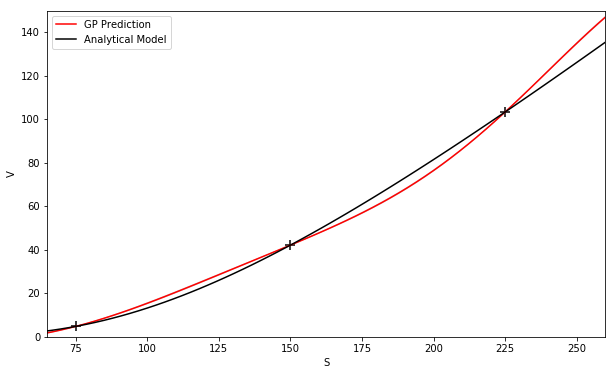

In [20]:
# predictionn plot with var band 
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.plot(lb+(ub-lb)*test_x_1.flatten(), y_pred_1, color = 'red', label = 'GP Prediction')
plt.plot(lb+(ub-lb)*test_x_1.flatten(), test_y_1, color = 'black', label = 'Analytical Model')
plt.scatter(lb+(ub-lb)*train_x_1, train_y_1, color = 'black', marker = '+', s = 100) 
plt.fill_between(lb+(ub-lb)*test_x_1.flatten(), (y_pred_1.T-2*sigma_1).flatten(), (y_pred_1.T+2*sigma_1).flatten(), color = 'grey', alpha=0.3)
plt.legend(loc = 'best', prop={'size':10})
plt.xlim([KC/2.0,2.0*KC])
plt.ylim([0,150])
plt.xlabel('S')
plt.ylabel('V')

# GP Put pricer

In [21]:
train_x_2 = np.array(np.linspace(0,1, training_number), dtype='float32').reshape(training_number, 1)
train_y_2 = []
for S in train_x_2:
    train_y_2.append(put(S))
    
testing_number = 100
test_x_2 = np.array(np.linspace(0,1, testing_number), dtype='float32').reshape(testing_number, 1)
test_y_2 = []
for S in test_x_2:
    test_y_2.append(put(S))

In [22]:
sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-05, 1000.0)) 
gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20)
gp.fit(train_x_2,train_y_2)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=RBF(length_scale=1), n_restarts_optimizer=20,
             normalize_y=False, optimizer='fmin_l_bfgs_b',
             random_state=None)

In [23]:
y_pred_2, sigma_2 = gp.predict(test_x_2, return_std=True)

(0, 40)

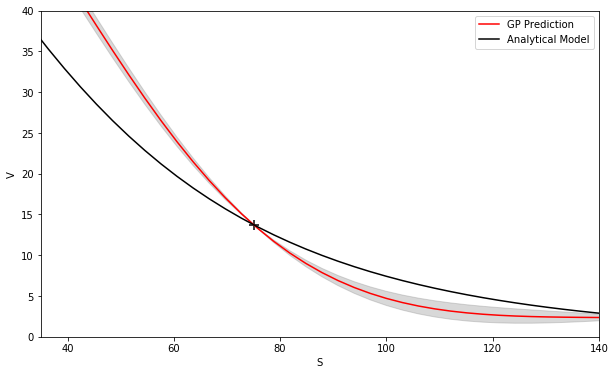

In [26]:
# prediction plot with var band 
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.plot(lb+(ub-lb)*test_x_2.flatten(), y_pred_2, color = 'red', label = 'GP Prediction')
plt.plot(lb+(ub-lb)*test_x_2.flatten(), test_y_2, color = 'black', label = 'Analytical Model')
plt.scatter(lb+(ub-lb)*train_x_2.flatten(), train_y_2, color = 'black', marker = '+', s = 100) 
plt.fill_between(lb+(ub-lb)*test_x_2.flatten(), (y_pred_2.T-2*sigma_2).flatten(), (y_pred_2.T+2*sigma_2).flatten(), color = 'grey', alpha=0.3)
plt.legend(loc = 'best', prop={'size':10})
plt.xlabel('S')
plt.ylabel('V')
plt.xlim([KP/2.0,2.0*KP])
plt.ylim([0,40])

# portfolio value

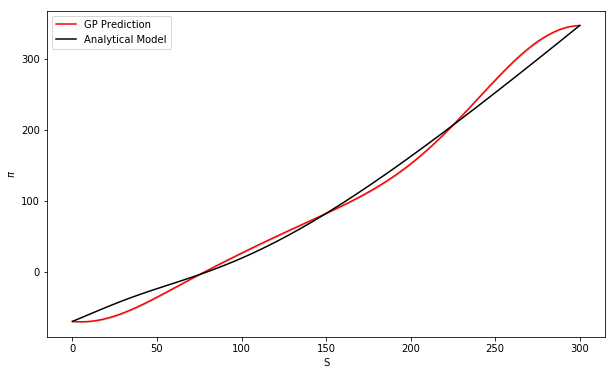

In [27]:
# portfolio prediction plot with var band 
y_pred = 2.0*y_pred_1 - y_pred_2 # long 2 calls and short a put
test_y = 2.0*np.array(test_y_1) - np.array(test_y_2)
sigma = np.sqrt(sigma_1*sigma_1 + sigma_2*sigma_2)
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.plot(lb+(ub-lb)*test_x_2.flatten(), y_pred, color = 'red', label = 'GP Prediction')
plt.plot(lb+(ub-lb)*test_x_2.flatten(), test_y.flatten(), color = 'black', label = 'Analytical Model')
plt.fill_between(lb+(ub-lb)*test_x_2.flatten(), (y_pred.T-2*sigma).flatten(), (y_pred.T+2*sigma).flatten(), color = 'grey', alpha=0.3)
plt.legend(loc = 'best', prop={'size':10})
plt.xlabel('S')
plt.ylabel('$\pi$')